<a href="https://colab.research.google.com/github/trilusa/SeniorDesign/blob/main/Algorithms/CNN/HRTF_Localizaiton_model4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

! pip install datasets[audio] yt-dlp

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, resample
import time

import tensorflow as tf
print(tf.__version__)

from IPython.display import Audio

from google.colab import data_table
data_table.enable_dataframe_formatter()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2.15.0


# Synthesize Data For Training
Load in a bunch of wave files, use tf utilities to clip into 1 second intervals. At 32 kS/s there should be 32000 samples.


In [2]:
target_rate = 32000
sample_rate=32000
window_L=1024
num_clips= 32

In [ ]:
#download music clips
# https://huggingface.co/datasets/google/MusicCaps
# https://colab.research.google.com/github/nateraw/download-musiccaps-dataset/blob/main/download_musiccaps.ipynb
import subprocess
import os
from pathlib import Path

from datasets import load_dataset, Audio


def download_clip(
    video_identifier,
    output_filename,
    start_time,
    end_time,
    tmp_dir='/tmp/musiccaps',
    num_attempts=5,
    url_base='https://www.youtube.com/watch?v='
):
    status = False

    command = f"""
        yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "{output_filename}" --download-sections "*{start_time}-{end_time}" {url_base}{video_identifier}
    """.strip()

    attempts = 0
    while True:
        try:
            output = subprocess.check_output(command, shell=True,
                                                stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as err:
            attempts += 1
            if attempts == num_attempts:
                return status, err.output
        else:
            break

    # Check if the video was successfully saved.
    status = os.path.exists(output_filename)
    return status, 'Downloaded'


def main(
    data_dir: str,
    sampling_rate: int = target_rate,
    limit: int = None,
    num_proc: int = 1,
    writer_batch_size: int = 100,
):
    """
    Download the clips within the MusicCaps dataset from YouTube.
    Args:
        data_dir: Directory to save the clips to.
        sampling_rate: Sampling rate of the audio clips.
        limit: Limit the number of examples to download.
        num_proc: Number of processes to use for downloading.
        writer_batch_size: Batch size for writing the dataset. This is per process.
    """

    ds = load_dataset('google/MusicCaps', split='train')
    if limit is not None:
        print(f"Limiting to {limit} examples")
        ds = ds.select(range(limit))

    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok=True, parents=True)

    def process(example):
        outfile_path = str(data_dir / f"{example['ytid']}.wav")
        status = True
        if not os.path.exists(outfile_path):
            status = False
            status, log = download_clip(
                example['ytid'],
                outfile_path,
                example['start_s'],
                example['end_s'],
            )

        example['audio'] = outfile_path
        example['download_status'] = status
        return example

    return ds.map(
        process,
        num_proc=num_proc,
        writer_batch_size=writer_batch_size,
        keep_in_memory=False
    ).cast_column('audio', Audio(sampling_rate=sampling_rate))

ds = main('./music_data', num_proc=8, limit=num_clips)

In [5]:
# ds.save_to_disk("/content/drive/My Drive/Senior Design/music/")
# pa.read_dataset("/content/drive/My Drive/Senior Design/music/music_dataset.parquet")

In [ ]:
# print(ds[0]['audio']['array'])
audio = []
sample_rate = ds[0]['audio']['sampling_rate']
err_cnt = 0
problem_files = []
for i in range(len(ds)):
    try:
        audio.append(ds[i]['audio']['array'])
    except FileNotFoundError:
        err_cnt += 1
        problem_files.append(i)
        print(f"File at idx {i} not found")
    # print(f"\r{i}", end="")
print(len(audio))

In [6]:
def compute_spectrogram(data, fs, window_L=1024):
    frequencies, times, Sxx = spectrogram(data, fs=fs, window='hamming',
                                          nperseg=window_L, noverlap=window_L//2, nfft=window_L, scaling='density')
    return frequencies, times, Sxx[:,:1+window_L//2]

def resample_audio(audio_data, orig_fs, target_fs):
    if orig_fs != target_fs:
        # Calculate the number of samples after resampling
        num_samples = round(len(audio_data) * float(target_fs) / orig_fs)
        audio_data = resample(audio_data, num_samples)
    return audio_data

def compute_LRspectra(L, R, fs, target_fs=32000,window_L=1024):
    L = resample_audio(L/(2**15), fs, target_fs)
    R = resample_audio(R/(2**15), fs, target_fs)
    _, _, Sxx_L = compute_spectrogram(L, target_fs,window_L)
    _, _, Sxx_R = compute_spectrogram(R, target_fs,window_L)
    Sxx_L = 10*np.log10(np.mean(Sxx_L, axis=1))  # calc spectrum by average over time slices
    Sxx_R = 10*np.log10(np.mean(Sxx_R, axis=1))
    maxLR = np.max([np.max(Sxx_L), np.max(Sxx_R)])  # normalize so max of L and R together maps to 0db, preserves relative amplitude
    Sxx_L -= maxLR
    Sxx_R -= maxLR
    return Sxx_L, Sxx_R

def plot_spectrogram(spect):
    plt.imshow(spect,aspect=1)
    plt.colorbar()
    plt.show()

In [8]:
## Run once
# file_name = "/content/drive/My Drive/Senior Design/hrtf/raw_whitenoise/raw_whitenoise2_all.pkl"
# df_hrtf=pd.read_pickle(file_name)
# df_hrtf['HRTF_L'], df_hrtf['HRTF_R'] = zip(*df_hrtf.apply(lambda row: compute_LRspectra(row['L'], row['R'], fs=row['sample_rate'], window_L=window_L), axis=1))
# df_hrtf['sample_rate'] = target_rate
# df_hrtf.drop(['L','R'], axis=1, inplace=True)
# df_hrtf['az'] = df_hrtf['az'].apply(lambda x: x-100) #rotate coordinate so centered
# df_hrtf['el'] = df_hrtf['el'].apply(lambda x: x-100)
# df_hrtf.to_pickle("/content/drive/My Drive/Senior Design/hrtf/HRTF_df.pkl")

In [9]:
df_hrtf=pd.read_pickle("/content/drive/My Drive/Senior Design/hrtf/HRTF_df.pkl")
df_hrtf['HRTF_L'] = df_hrtf['HRTF_L'].apply(lambda x: x.astype(np.float32))
df_hrtf['HRTF_R'] = df_hrtf['HRTF_R'].apply(lambda x: x.astype(np.float32))
df_hrtf['az'] = df_hrtf['az'].apply(lambda x: np.float16(x))
df_hrtf['el'] = df_hrtf['el'].apply(lambda x: np.float16(x))
# df_hrtf.head()

In [3]:
window_L=1024
num_spec_per_example = 3
sample_per_slice = 1 * sample_rate
front_cuttoff_idx = 1*sample_per_slice

In [10]:
raw_training_spectrograms = []


for a in audio:
    total_seconds = a.shape[0] // sample_rate  # total available full seconds

    for i in range(num_spec_per_example):
        idx = i * sample_per_slice
        seg = a[front_cuttoff_idx+idx : idx+sample_per_slice+front_cuttoff_idx]
        # seg /= (2**15) #normalize

        stft = tf.signal.stft(seg, frame_length=window_L, frame_step=window_L//2, fft_length=window_L)
        spec = 10*tf.math.log(tf.abs(stft),10)
        # power_spectrogram = tf.math.pow(spectrogram, 2)
        raw_training_spectrograms.append(tf.cast(spec,dtype=tf.float32))

    # training_examples.append(spectrograms)
print(len(raw_training_spectrograms))
print(raw_training_spectrograms[0].shape)
# plot_spectrogram(raw_training_spectrograms[0])
# raw_training_spectrograms_ds = tf.data.Dataset.from_tensor_slices(raw_training_spectrograms)
# tf.data.experimental.save(raw_training_spectrograms_ds, '/content/drive/My Drive/Senior Design/synth_data/')
# tensor_spec = raw_training_spectrograms_ds.element_spec
# print(tensor_spec)
del(audio)

96
(61, 513)


In [11]:
num_spectrograms = len(raw_training_spectrograms)
num_hrtfs = len(df_hrtf['HRTF_L'].values)
total_examples = num_spectrograms * num_hrtfs
print(f"{total_examples/1e6} Million Examples Prepared")

0.450432 Million Examples Prepared


In [12]:
#finally works!!!
HRTF_L_dataset = tf.data.Dataset.from_tensor_slices(df_hrtf['HRTF_L'].values.tolist())
HRTF_R_dataset = tf.data.Dataset.from_tensor_slices(df_hrtf['HRTF_R'].values.tolist())
az_dataset = tf.data.Dataset.from_tensor_slices(df_hrtf['az'].values.tolist())
el_dataset = tf.data.Dataset.from_tensor_slices(df_hrtf['el'].values.tolist())

HRTF_dataset = tf.data.Dataset.zip( (HRTF_L_dataset, HRTF_R_dataset, az_dataset, el_dataset))
spectrogram_dataset = tf.data.Dataset.from_tensor_slices(raw_training_spectrograms)

def cartesian_product(HRTF_L, HRTF_R, az, el):
    return spectrogram_dataset.map(lambda s: (HRTF_L, HRTF_R, az, el, s))

def process_elements(HRTF_L, HRTF_R, az, el, spec ):
    # HRTF_L, HRTF_R, az, el, spec = all_examples_ds_tuple
    HRTF_stacked = tf.stack([HRTF_L, HRTF_R], axis=1)  # Shape: (513, 2)
    spectrogram_stacked = tf.stack([spec, spec], axis=2)  # Duplicate spectrogram across a new dimension
    input_tensor = spectrogram_stacked + HRTF_stacked
    target_tensor = [az, el]
    return input_tensor, target_tensor

all_examples_ds = HRTF_dataset.flat_map(cartesian_product)
all_examples_ds = all_examples_ds.map(process_elements)

# all_examples_ds.to_pickle('/content/drive/My Drive/Senior Design/synth_data/all_examples_ds.pkl')


In [4]:
epochs=50
dropout=.5
learning_rate = 0.01
num_training_examples = int(150000)
batch_size = 256
train_size = int(num_training_examples * .8)


In [1]:

all_examples_ds = all_examples_ds.shuffle(buffer_size=50000)
all_examples_ds_subsample =  all_examples_ds.take(num_training_examples)


train_dataset = all_examples_ds_subsample.take(train_size)
validation_dataset = all_examples_ds_subsample.skip(train_size)

train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


NameError: name 'all_examples_ds' is not defined

#Model Training




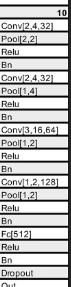

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, Dropout


model = Sequential([
    # assume  input shape  (61, 513, 2)
    Conv2D(filters=32, kernel_size=(2, 4), padding='same', activation='relu', input_shape=(61, 513, 2)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(2, 4), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(1, 4)),

    Conv2D(filters=64, kernel_size=(3, 16), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(1, 2)),

    Conv2D(filters=128, kernel_size=(1, 2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(1, 2)),

    Flatten(),
    Dense(units=512, activation='relu'),
    BatchNormalization(),
    Dropout(rate=dropout),

    Dense(units=2, activation='linear')
])
optimizer = tf.keras.optimizers.Adam(learning_rate)

model.compile(optimizer=optimizer, loss='MSE', metrics=['mae'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 513, 32)       544       
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 256, 32)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 30, 256, 32)       128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 256, 32)       8224      
                                                                 
 batch_normalization_1 (Bat  (None, 30, 256, 32)       128       
 chNormalization)                                                
                                                        

In [15]:
# import gc
# tf.keras.backend.clear_session()
# class GC_Callback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     gc.collect()

In [34]:
from datetime import datetime
now_str = datetime.now().strftime("%Y%m%d-%H%M%S")
folder_path = f"/content/drive/My Drive/Senior Design/models/{now_str}"
os.makedirs(folder_path, exist_ok=True)
keras_file_path = f"{folder_path}/hrtf_localization_model_{now_str}.keras"

class Model_Save_Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    model.save(keras_file_path)

In [35]:
training_data_type = "real"
valdiation_data_type = "real"

# meta_string=f"""{num_clips} Audio Clips
# sample_rate={sample_rate}
# spectrogam window len = {window_L}
# {num_spec_per_example} spectrograms per music clip
# Spectrgrams are {sample_per_slice/sample_rate} seconds ({sample_per_slice} samples @ {sample_rate/1000}khz)
# Training set = {int(0.8*num_training_examples)} examples ({training_data_type} data)
# Validation set = {int(0.2*num_training_examples)}examples ({valdiation_data_type} data)
# Batch size = {batch_size}, learning rate = {learning_rate}
# dropout rate = {dropout}\n planned epochs = {epochs}
# Model Location = {folder_path}"""

meta_string=f"""sample_rate={sample_rate}
spectrogam window len = {1024}
Spectrgrams are {sample_per_slice/sample_rate} seconds ({sample_per_slice} samples @ {sample_rate/1000}khz)
Training set = {int(0.8*num_training_examples)} examples ({training_data_type} data)
Validation set = {int(0.2*num_training_examples)}examples ({valdiation_data_type} data)
Batch size = {batch_size}, learning rate = {learning_rate}
dropout rate = {dropout}
planned epochs = {epochs}
Model Location = {folder_path}"""
print(meta_string)
with open(f"{folder_path}/metadata{now_str}.txt", 'w') as file:
    file.write(meta_string)

sample_rate=32000
spectrogam window len = 1024
Spectrgrams are 1.0 seconds (32000 samples @ 32.0khz) 
Training set = 8000 examples (real data)
Validation set = 2000examples (real data)
Batch size = 256, learning rate = 0.01
dropout rate = 0.5
planned epochs = 50
Model Location = /content/drive/My Drive/Senior Design/models/20240425-063538


In [36]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger(f"{folder_path}/training_history.csv")
# log_dir = f"{folder_path}/logs"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
t0=time.time()

history = model.fit(
    real_training_dataset,
    epochs=epochs,
    validation_data=real_validation_dataset,
    callbacks=[Model_Save_Callback(), csv_logger]
)
total_time = time.time()-t0
total_time_str = f"Total training time: {datetime.fromtimestamp(total_time).strftime('%H:%M:%S')}"
print(total_time_str)
with open(f"{folder_path}/metadata{now_str}.txt", 'a') as file:
    file.write("\n"+total_time_str)

Epoch 1/50
 6/32 [====>.........................] - ETA: 5s - loss: 6771.0098 - mae: 78.2683

32/32 [==============================] - 13s 413ms/step - loss: 1912.7301 - mae: 32.8317 - val_loss: 1197.6079 - val_mae: 27.9669
Epoch 2/50
32/32 [==============================] - 10s 299ms/step - loss: 318.4405 - mae: 13.7601 - val_loss: 418.8414 - val_mae: 16.1799
Epoch 3/50
32/32 [==============================] - 9s 291ms/step - loss: 219.1801 - mae: 11.3302 - val_loss: 277.6830 - val_mae: 12.4819
Epoch 4/50
32/32 [==============================] - 9s 292ms/step - loss: 171.7544 - mae: 10.0909 - val_loss: 306.8087 - val_mae: 13.4230
Epoch 5/50
32/32 [==============================] - 9s 293ms/step - loss: 150.6484 - mae: 9.4657 - val_loss: 306.4330 - val_mae: 13.2057
Epoch 6/50
32/32 [==============================] - 9s 291ms/step - loss: 131.5697 - mae: 8.9263 - val_loss: 295.4121 - val_mae: 13.5473
Epoch 7/50
32/32 [==============================] - 9s 297ms/step - loss: 111.9635 - mae: 8.2830 - val_loss: 401.1718 - val_mae: 16.0836
Epoch 8/50
32/32 [==========================

In [ ]:


#save model manually
# folder_path = f"/content/drive/My Drive/Senior Design/models/{now_str}"
# os.makedirs(folder_path, exist_ok=True)
# file_path = f"{folder_path}/hrtf_localization_model_{now_str}.keras"
# model.save(file_path)

#load model manually
folder_path = f"/content/drive/My Drive/Senior Design/models/20240424-184720"
from keras.models import load_model
model = load_model(f"{folder_path}/hrtf_localization_model_20240424-184720.keras")
model.summary()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


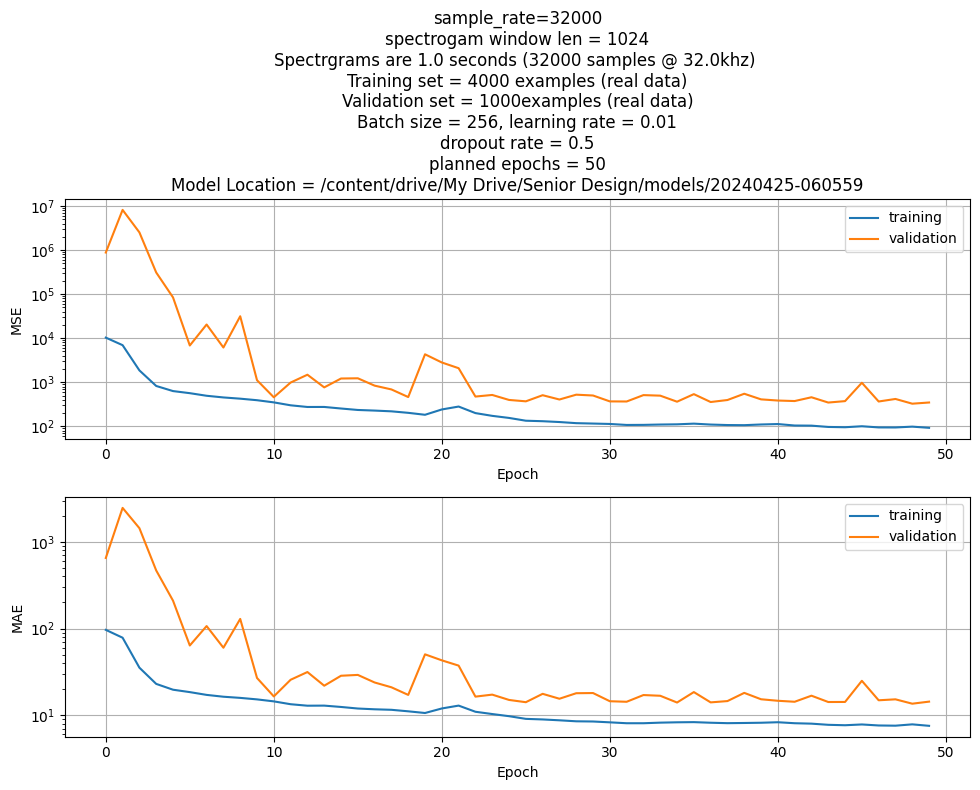

In [18]:
import matplotlib.pyplot as plt
print(history.history.keys())
mse= history.history['loss']
val_mse=history.history['val_loss']

mae= history.history['mae']
val_mae=history.history['val_mae']
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(2,1,1)

plt.title(meta_string)

plt.plot(mse[:],label="training")
plt.plot(val_mse,label="validation")
plt.ylabel("MSE")
plt.legend()
ax.set_yscale('log')
plt.xlabel("Epoch")
plt.grid(True)
# plt.ylim((0,1000))

ax=plt.subplot(2,1,2)
plt.plot(mae[:],label="training")
plt.plot(val_mae,label="validation")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.tight_layout()
plt.legend()
ax.set_yscale('log')
plt.grid(True)

fig.savefig(f"{folder_path}/training_history.png")

# Model Validation
Will predict the training set, validation set (synthetic) and the real recordings.

In [7]:
def split_audio(row,T=1):
    # Calculate the number of samples per 1-second audio
    fs = row['sample_rate']
    L=row['L']
    R=row['R']
    # if fs != target_rate:
    #     L = resample_audio(L, fs, target_rate)
    #     R = resample_audio(R, fs, target_rate)
    N=int(T*fs)
    new_rows = []
    num_segs = len(row['L'])/N
    for i in range(int(num_segs)):
        start_idx = i * N
        end_idx = start_idx + N
        new_row = row.copy()
        new_row['L'] = L[start_idx:end_idx]
        new_row['R'] = R[start_idx:end_idx]
        row['sample_rate'] = target_rate
        new_row['seq_id'] = i
        new_rows.append(new_row)
    return pd.DataFrame(new_rows)

In [5]:
## run once - load and process real receording
# df1 = pd.read_pickle("/content/drive/My Drive/Senior Design/raw_data/combined/raw_recordings1.pkl")
# df2 = pd.read_pickle("/content/drive/My Drive/Senior Design/raw_data/combined/raw_recordings2.pkl")
# df3 = pd.read_pickle("/content/drive/My Drive/Senior Design/raw_data/combined/raw_recordings3.pkl")
# df = pd.concat([df1,df2,df3])
# df.to_pickle("/content/drive/My Drive/Senior Design/raw_data/combined/raw_recordings_all.pkl")

# print(df1['L'].apply(len).value_counts()+df2['L'].apply(len).value_counts()+df3['L'].apply(len).value_counts())
# del df1,df2,df3

In [10]:
print(df['sample_rate'].value_counts())
print(df['L'].apply(len).value_counts())


sample_rate
32000    13233
Name: count, dtype: int64
L
160000    13233
Name: count, dtype: int64


az   el   sound_type  sample_rate  \
0      10   50      CHINESE        32000   
1      10   50        MUSIC        32000   
2      10   50       PRIMES        32000   
3      10   50  WHITE_NOISE        32000   
4      10   52      CHINESE        32000   
...   ...  ...          ...          ...   
4636  190  142      BRAINFM        32000   
4637  190  144      BRAINFM        32000   
4638  190  146      BRAINFM        32000   
4639  190  148      BRAINFM        32000   
4640  190  150      BRAINFM        32000   

                                                      L  \
0     [0.019000976774372583, 0.002367167834742577, 0...   
1     [-0.09921931874983388, -0.15053672287386433, -...   
2     [0.031276489247556105, 0.017641936772744025, 0...   
3     [0.035330606425800944, 0.005617767660602612, -...   
4     [-0.025910238861171806, -0.008038543585730501,...   
...                                                 ...   
4636  [-0.006559703474941284, 0.003967686185585717, ...   
4637  [0.0058616066674905595, -0.0007853151000494449...   
4638  [0.000725110090779367, 0.0436412685874332, 0.0...   
4639  [0.026447677756947, -0.06601050471536712, -0.0...   
4640  [-0.019422697308799357, -0.025511676529216588,...   

                                                      R  
0     [0.07594102222363269, 0.13160616801719968, 0.1...  
1     [-0.05249716476540543, -0.07576881282705683, -...  
2     [0.02018256984475144, 0.007219812199400076, -0...  
3     [0.20321381467372615, 0.07222382562900678, 0.0...  
4     [0.025369609413520226, -0.004527976407052889, ...  
...                                                 ...  
4636  [0.000927807846027425, -0.04287377837368228, -...  
4637  [-0.14077210702037082, -0.14522934876307353, -...  
4638  [-0.21570963550018019, -0.22614077710650363, -...  
4639  [-0.004541103991977002, 0.0055623009075930745,...  
4640  [-0.09839309465749176, -0.11978300681766192, -...  

[13233 rows x 6 columns]

In [8]:
# df = pd.read_pickle("/content/drive/My Drive/Senior Design/raw_data/combined/raw_recordings_all.pkl")
# df['L'] = df['L'] .apply(lambda x: x.astype(np.float32))
# df['R'] = df['R'].apply(lambda x: x.astype(np.float32))
# df['az'] = df['az'].apply(lambda x: np.float16(x))
# df['el'] = df['el'].apply(lambda x: np.float16(x))
# df['sample_rate'] = 32000
# df = pd.concat(df.apply(lambda row: split_audio(row,T=1), axis=1).tolist(), ignore_index=True)

# df.to_pickle("/content/drive/My Drive/Senior Design/raw_data/combined/raw_recordings_split_all.pkl")
# len(df.index)

In [8]:
def process_elements(L, R, az, el):
    # L = tf.cast(L, tf.float32)
    # R = tf.cast(R, tf.float32)
    stftL = tf.signal.stft(L, frame_length=window_L, frame_step=window_L//2, fft_length=window_L)
    stftR = tf.signal.stft(R, frame_length=window_L, frame_step=window_L//2, fft_length=window_L)
    stftL = 10*tf.math.log(tf.abs(stftL)+1e-8,10)
    stftR = 10*tf.math.log(tf.abs(stftR)+1e-8,10)
    input_tensor = tf.stack([stftL, stftR], axis=2)  # Shape: (513, 2)
    target_tensor = tf.convert_to_tensor([az, el], dtype=tf.int16)
    return pd.Series([input_tensor, target_tensor])

In [31]:
# df_all = pd.read_pickle("/content/drive/My Drive/Senior Design/raw_data/combined/raw_recordings_split_all.pkl")
# print(len(df_all))
df_all['az'] = df_all['az']-100
df_all['el'] = df_all['el']-100
# df_all['sample_rate'] = 32000
num_training_examples = 10000
df = df_all.sample(num_training_examples)

df[['input', 'target']] = df.apply(lambda row: process_elements(row['L'], row['R'], row['az'], row['el']), axis=1, result_type='expand')
df.drop(columns=['L','R'], inplace=True)
df.drop(columns=['az','el','sound_type','sample_rate','seq_id'], inplace=True)
df.to_pickle("/content/drive/My Drive/Senior Design/raw_data/combined/real_inputs_targets.pkl")

In [32]:
# df = pd.read_pickle("/content/drive/My Drive/Senior Design/raw_data/combined/real_inputs_targets.pkl")
print(len(df))
inputs = tf.stack(df['input'].tolist(), axis=0)  # Stack if they are already tensors
targets = tf.stack(df['target'].tolist(), axis=0)

training_size=int(.8*len(df))
real_dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
real_training_set = real_dataset.take(training_size)
real_validation_set = real_dataset.skip(training_size)

# Batch the dataset
batch_size = 256  # Example batch size, adjust as needed
real_validation_dataset = real_validation_set.batch(batch_size)
real_training_dataset = real_training_set.batch(batch_size)

10000


In [15]:
#convert to tenors
# L_dataset = tf.data.Dataset.from_tensor_slices(df['L'].values.tolist())
# R_dataset = tf.data.Dataset.from_tensor_slices(df['R'].values.tolist())
# az_dataset = tf.data.Dataset.from_tensor_slices(df['az'].values.tolist())
# el_dataset = tf.data.Dataset.from_tensor_slices(df['el'].values.tolist())
# real_validation_dataset = tf.data.Dataset.zip( (L_dataset, R_dataset, az_dataset, el_dataset))

# def compute_spectrogram(entry):
#         entry = tf.cast(entry, tf.float32)
#         stft = tf.signal.stft(entry, frame_length=window_L, frame_step=window_L//2, fft_length=window_L)
#         spec = 10*tf.math.log(tf.abs(stft),10)
#         return spec

# L_dataset = L_dataset.map(compute_spectrogram)
# R_dataset = R_dataset.map(compute_spectrogram)



# Now you can use the dataset with the model
# real_prediction = model.predict(dataset)

# real_validation_dataset = real_validation_dataset.map(process_elements)
# real_validation_dataset = real_validation_dataset.shuffle(buffer_size=50000)
# df_hrtf['HRTF_L'], df_hrtf['HRTF_R'] = zip(*df_hrtf.apply(lambda row: compute_LRspectrograms(row['L'], row['R'], fs=row['sample_rate'], window_L=window_L), axis=1))


In [22]:
#manual validation
# val_prediction = model.predict(validation_dataset, verbose=2)
# train_prediction = model.predict(train_dataset, verbose=2)
real_prediction = model.predict(real_validation_dataset)

4/4 [==============================] - 0s 83ms/step


In [23]:
# val_targets = []
# for inputs, targets in validation_dataset:
#   val_targets.append(targets.numpy())
# val_targets = np.concatenate(val_targets)

# train_targets = []
# for inputs, targets in train_dataset:
#   train_targets.append(targets.numpy())
# train_targets = np.concatenate(train_targets)

real_targets = []
for inputs, targets in real_validation_dataset:
  real_targets.append(targets.numpy())
real_targets = np.concatenate(real_targets)

In [25]:
# validaiton error
# val_target_az = val_targets[:,0]
# val_target_el = val_targets[:,1]
# val_result_az = val_prediction[:,0]
# val_result_el = val_prediction[:,1]
# val_err_az = val_target_az - val_result_az
# val_err_el = val_target_el - val_result_el


# #train
# train_err = train_targets - train_prediction
# train_err_az = train_target_az - train_result_az
# train_err_el = train_target_el  - train_result_el


# train_target_az = train_targets[:,0]
# train_target_el = train_targets[:,1]
# train_result_az = train_prediction[:,0]
# train_result_el = train_prediction[:,1]

#real
real_target_az = real_targets[:,0]
real_target_el = real_targets[:,1]
real_result_az = real_prediction[:,0]
real_result_el = real_prediction[:,1]

real_err_az = real_target_az - real_result_az
real_err_el = real_target_el - real_result_el



# print(f"Val Err: {val_err}")
# print(f"Train Err {train_err}")
# print(f"Real Err {real_err}")


In [26]:
# df = pd.DataFrame(real_target_az, real_target_el, real_result_az, real_result_el,
#         columns=['real_target_az', 'real_target_el', 'real_result_az','real_result_el'])
# df.to_csv(f"{folder_path}/real_validation_results.csv")

# df = pd.DataFrame(val_target_az, val_target_el, val_result_az, val_result_el,
#                   train_target_az, train_target_el, train_result_az, train_result_el,
#                   real_target_az, real_target_el, real_result_az, real_result_el,
#         columns=['val_target_az', 'val_target_el', 'val_result_az','val_result_el',
#                  'train_target_az','train_target_el', 'train_result_az', 'train_result_el\n'
#                 'real_target_az', 'real_target_el', 'real_result_az', 'real_result_el\n'
#                  ])

# data_val = {
#     'val_target_az': val_target_az,
#     'val_target_el': val_target_el,
#     'val_result_az': val_result_az,
#     'val_result_el': val_result_el
#     }

# data_train = {
#     'train_target_az': train_target_az,
#     'train_target_el': train_target_el,
#     'train_result_az': train_result_az,
#     'train_result_el': train_result_el
# }
data_real = {
    'real_target_az': real_target_az,
    'real_target_el': real_target_el,
    'real_result_az': real_result_az,
    'real_result_el': real_result_el,
}
# df_val = pd.DataFrame(data_val)
# df_train = pd.DataFrame(data_train)
df_real = pd.DataFrame(data_real)

# df = pd.concat([df_val, df_train, df_real])
# df_val.to_csv(f"{folder_path}/val_results.csv")
# df_train.to_csv(f"{folder_path}/train_results.csv")
df_real.to_csv(f"{folder_path}/real_results.csv")

In [27]:
df_val = pd.read_csv(f"{folder_path}/val_results.csv")
df_train = pd.read_csv(f"{folder_path}/train_results.csv")
df_real = pd.read_csv(f"{folder_path}/real_results.csv")

val_target_az = df_val['val_target_az'].values
val_target_el = df_val['val_target_el'].values
val_result_az = df_val['val_result_az'].values
val_result_el = df_val['val_result_el'].values

train_target_az = df_train['train_target_az'].values
train_target_el = df_train['train_target_el'].values
train_result_az = df_train['train_result_az'].values
train_result_el = df_train['train_result_el'].values

real_target_az = df_real['real_target_az'].values
real_target_el = df_real['real_target_el'].values
real_result_az = df_real['real_result_az'].values
real_result_el = df_real['real_result_el'].values

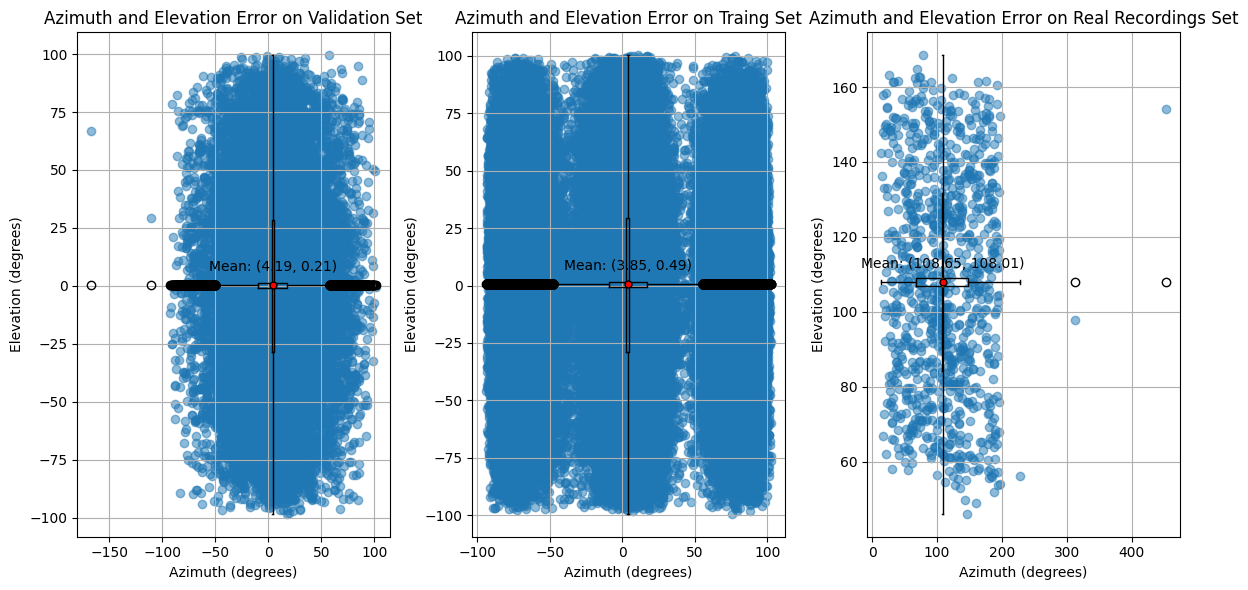

In [36]:
# Scatter plot
fig=plt.figure(figsize=(12, 6))  # Set the figure size for better visibility
r=1;c=3

plt.subplot(r,c,1)
plt.scatter(val_err_az, val_err_el, label='Validation', alpha=0.5)
plt.title("Azimuth and Elevation Error on Validation Set")
plt.xlabel("Azimuth (degrees)")
plt.ylabel("Elevation (degrees)")

mean_val_err_az, mean_val_err_el = np.mean(val_err_az), np.mean(val_err_el)
plt.scatter(mean_val_err_az, mean_val_err_el, color='red', s=25, edgecolors='black', zorder=5)

plt.boxplot(val_err_az, vert=False, positions=[mean_val_err_el], widths=2, manage_ticks=False)  # Horizontal boxplot for x
plt.boxplot(val_err_el, positions=[mean_val_err_az], widths=2, manage_ticks=False)  # Vertical boxplot for y

# Annotating the mean point
plt.annotate('Mean: ({:.2f}, {:.2f})'.format(mean_val_err_az, mean_val_err_el),
             (mean_val_err_az, mean_val_err_el),
             textcoords="offset points",
             xytext=(0,10),
             ha='center')
# plt.xlim((-100,100))
# plt.ylim((-100,100))
plt.grid(True)
# plt.axis('square')


plt.subplot(r,c,2)
plt.scatter(train_err_az, train_err_el, label='Training', alpha=0.5)
plt.title("Azimuth and Elevation Error on Traing Set")
plt.xlabel("Azimuth (degrees)")
plt.ylabel("Elevation (degrees)")

mean_train_err_az, mean_train_err_el = np.mean(train_err_az), np.mean(train_err_el)
plt.scatter(mean_train_err_az, mean_train_err_el, color='red', s=25, edgecolors='black', zorder=5)

plt.boxplot(train_err_az, vert=False, positions=[mean_train_err_el], widths=2, manage_ticks=False)  # Horizontal boxplot for x
plt.boxplot(train_err_el, positions=[mean_train_err_az], widths=2, manage_ticks=False)  # Vertical boxplot for y

# Annotating the mean point
plt.annotate('Mean: ({:.2f}, {:.2f})'.format(mean_train_err_az, mean_train_err_el),
             (mean_train_err_az, mean_train_err_el),
             textcoords="offset points",
             xytext=(0,10),
             ha='center')
# plt.xlim((-100,100))
# plt.ylim((-100,100))
plt.grid(True)



# Plotting

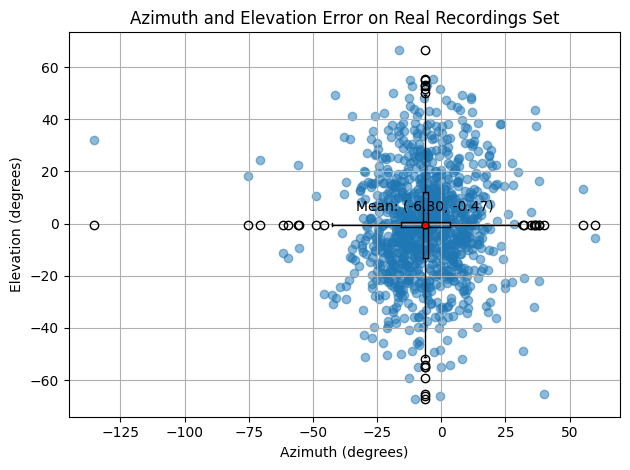

In [27]:


# plt.subplot(r,c,3)
plt.scatter(real_err_az, real_err_el, label='Real Recording', alpha=0.5)
plt.title("Azimuth and Elevation Error on Real Recordings Set")
plt.xlabel("Azimuth (degrees)")
plt.ylabel("Elevation (degrees)")

mean_real_err_az, mean_real_err_el = np.mean(real_err_az), np.mean(real_err_el)
plt.scatter(mean_real_err_az, mean_real_err_el, color='red', s=25, edgecolors='black', zorder=5)

plt.boxplot(real_err_az, vert=False, positions=[mean_real_err_el], widths=2, manage_ticks=False)  # Horizontal boxplot for x
plt.boxplot(real_err_el, positions=[mean_real_err_az], widths=2, manage_ticks=False)  # Vertical boxplot for y

# Annotating the mean point
plt.annotate('Mean: ({:.2f}, {:.2f})'.format(mean_real_err_az, mean_real_err_el),
             (mean_real_err_az, mean_real_err_el),
             textcoords="offset points",
             xytext=(0,10),
             ha='center')
# plt.xlim((-100,100))
# plt.ylim((-100,100))
plt.grid(True)
# plt.axis('square')

plt.tight_layout()
fig.savefig(f"{folder_path}/real_azimuth_elevation_error.png")


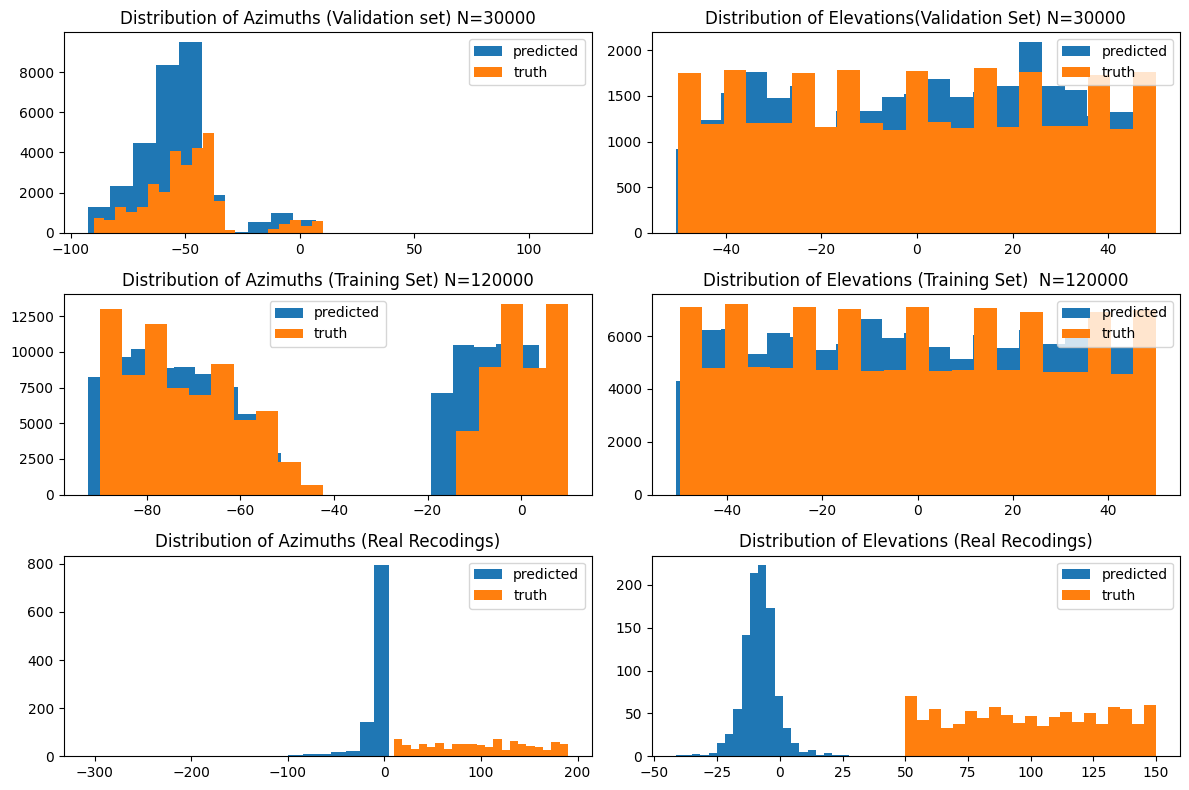

In [32]:
#show histograms of the distrubution of model output

bins=21
fig=plt.figure(figsize=(12,8))
r=3; c=2


plt.subplot(r,c,1)
plt.hist(val_result_az,label="predicted",bins=bins)
plt.hist(val_target_az,label="truth",bins=bins)
plt.legend()
plt.title(f"Distribution of Azimuths (Validation set) N={len(val_result_az)}")

plt.subplot(r,c,2)
plt.hist(val_result_el,label="predicted",bins=bins)
plt.hist(val_target_el,label="truth",bins=bins)
plt.legend()
plt.title(f"Distribution of Elevations(Validation Set) N={len(val_result_el)}")

plt.subplot(r,c,3)
plt.hist(train_result_az,label="predicted",bins=bins)
plt.hist(train_target_az,label="truth",bins=bins)
plt.legend()
plt.title(f"Distribution of Azimuths (Training Set) N={len(train_result_az)}")

plt.subplot(r,c,4)
plt.hist(train_result_el,label="predicted",bins=bins)
plt.hist(train_target_el,label="truth",bins=bins)
plt.legend()
plt.title(f"Distribution of Elevations (Training Set)  N={len(train_result_el)}")



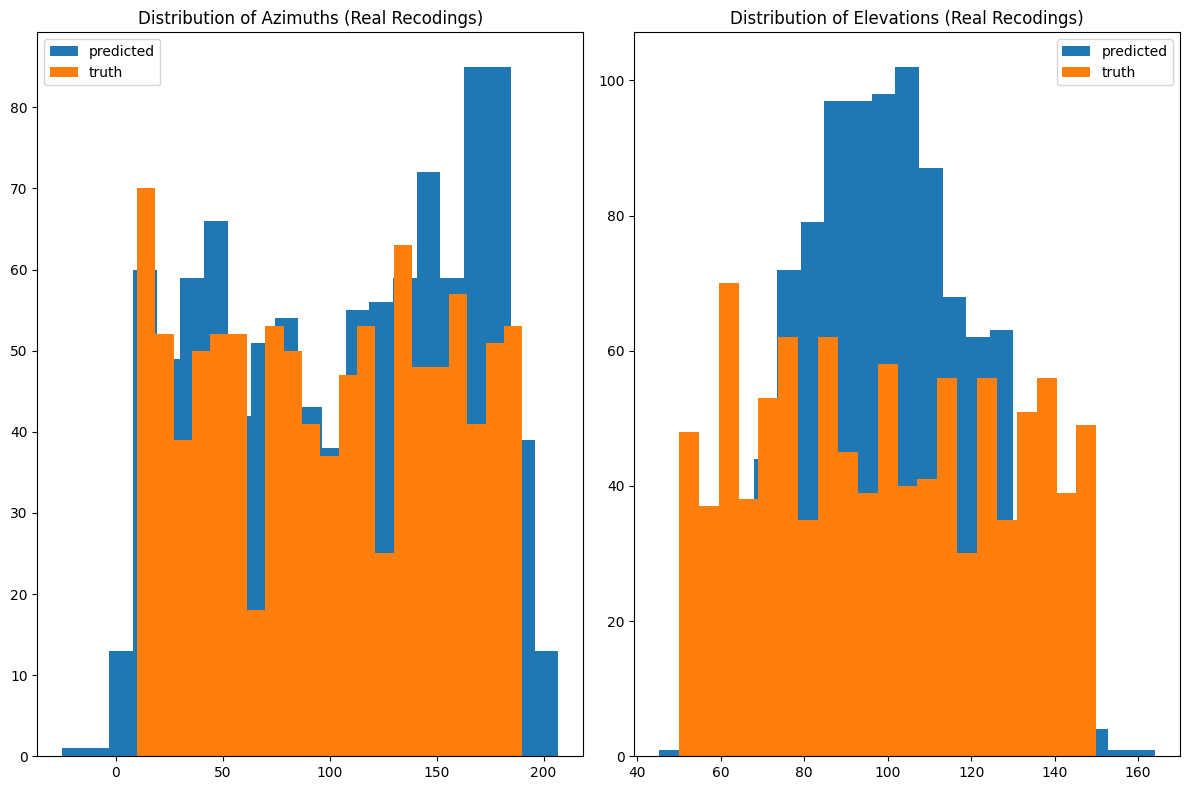

In [29]:
bins=21
fig=plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.hist(real_result_az,label="predicted",bins=bins)
plt.hist(real_target_az,label="truth",bins=bins)
plt.legend()
plt.title("Distribution of Azimuths (Real Recodings)")

plt.subplot(1,2,2)
plt.hist(real_result_el,label="predicted",bins=bins)
plt.hist(real_target_el,label="truth",bins=bins)
plt.legend()
plt.title("Distribution of Elevations (Real Recodings)")

plt.tight_layout()
fig.savefig(f"{folder_path}/real_distributions.png")

In [ ]:
# fig=plt.figure()

# # plt.hist(val_result_el,label="predicted",bins=bins)
# # plt.hist(val_target_el,label="truth",bins=bins)
# # plt.legend()
# # plt.title("Distribution of Elevations in Predicted and GT (Validation Set)")
# # fig.savefig(f"{folder_path}/validation_elevation_distribution.png")

In [ ]:
# fig=plt.figure()
# # plt.hist(train_result_az,label="predicted",bins=bins)
# # plt.hist(train_target_az,label="truth",bins=bins)
# # plt.legend()
# # plt.title("Distribution of Azimuths in Predicted and GT (Training Set)")
# # fig.savefig(f"{folder_path}/training_azimuth_distribution.png")

In [ ]:
# fig=plt.figure()
# # plt.hist(train_result_el,label="predicted",bins=bins)
# # plt.hist(train_target_el,label="truth",bins=bins)
# # plt.legend()
# # plt.title("Distribution of Elevations in Predicted and GT (Training Set)")
# fig.savefig(f"{folder_path}/training_elevation_distribution.png")

In [ ]:
#azimuth val
# fig=plt.figure()
# plt.scatter(val_target_az,val_result_az,label="az")
# plt.plot([-90,90],[-90,90],'k')
# plt.xlabel("True Azimuth")
# plt.ylabel("Predicted Azimuth")
# plt.axis('square')
# plt.ylim((-90,90))
# plt.xlim((-90,90))
# plt.title("Azimuth accuracy for Validation Set")
# plt.grid(True)
# fig.savefig(f"{folder_path}/val_azimuth_diagonal.png")

In [ ]:
# #elevation val
# fig=plt.figure()
# # plt.scatter(val_target_el,val_result_el,label="el")
# # plt.plot([-90,90],[-90,90],'k')
# # plt.xlabel("True Elevation")
# # plt.ylabel("Predicted Elevation")
# # plt.axis('square')
# # plt.ylim((-90,90))
# # plt.xlim((-90,90))
# # plt.title("Elevation Accuracy for Validation set")
# # plt.grid(True)
# fig.savefig(f"{folder_path}/val_elevation_diagonal.png")

In [ ]:
#azimuth train
# fig=plt.figure()

# fig.savefig(f"{folder_path}/training_azimuth_diagonal.png")

In [ ]:
#elevation train
# fig=plt.figure()

# fig.savefig(f"{folder_path}/training_elevation_diagonal.png")

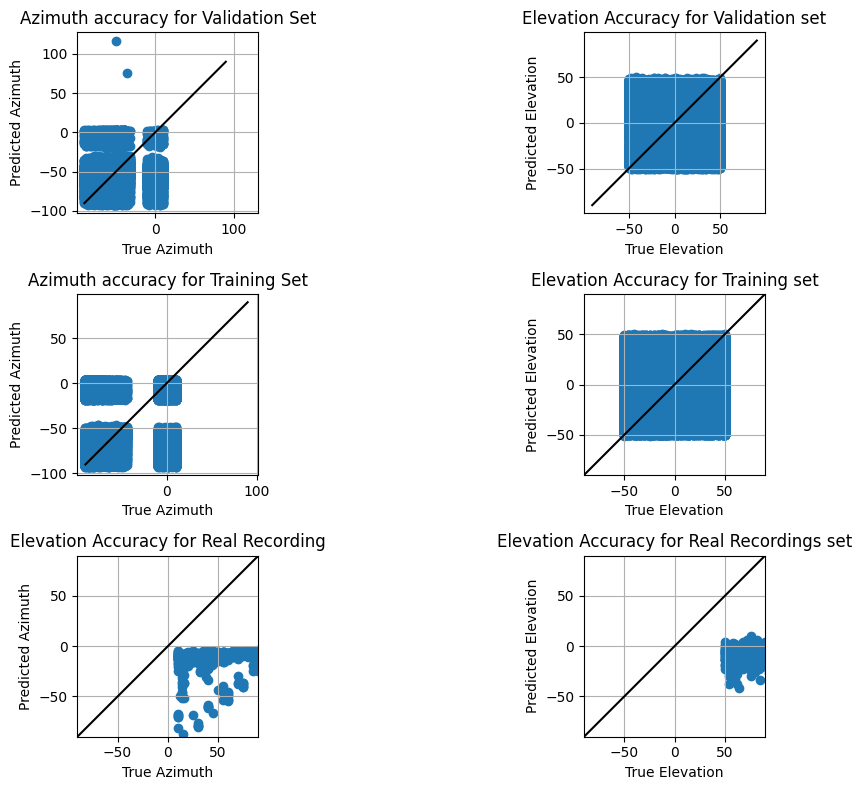

In [35]:
#show accuracy plot of the distrubution of model output
# should be diagional line

fig=plt.figure(figsize=(12,8))

r=3; c=2

plt.subplot(r,c,1)
plt.scatter(val_target_az,val_result_az,label="az")
plt.plot([-90,90],[-90,90],'k')
plt.xlabel("True Azimuth")
plt.ylabel("Predicted Azimuth")
plt.axis('square')
# plt.ylim((-90,90))
# plt.xlim((-90,90))
plt.title("Azimuth accuracy for Validation Set")
plt.grid(True)

plt.subplot(r,c,2)
plt.scatter(val_target_el,val_result_el,label="el")
plt.plot([-90,90],[-90,90],'k')
plt.xlabel("True Elevation")
plt.ylabel("Predicted Elevation")
plt.axis('square')
# plt.ylim((-90,90))
# plt.xlim((-90,90))
plt.title("Elevation Accuracy for Validation set")
plt.grid(True)

plt.subplot(r,c,3)
plt.scatter(train_target_az,train_result_az,label="az")
plt.plot([-90,90],[-90,90],'k')
plt.xlabel("True Azimuth")
plt.ylabel("Predicted Azimuth")
plt.axis('square')
# plt.ylim((-90,90))
# plt.xlim((-90,90))
plt.title("Azimuth accuracy for Training Set")
plt.grid(True)

plt.subplot(r,c,4)
plt.scatter(train_target_el,train_result_el,label="el")
plt.plot([-90,90],[-90,90],'k')
plt.xlabel("True Elevation")
plt.ylabel("Predicted Elevation")
plt.axis('square')
plt.ylim((-90,90))
plt.xlim((-90,90))
plt.title("Elevation Accuracy for Training set")
plt.grid(True)


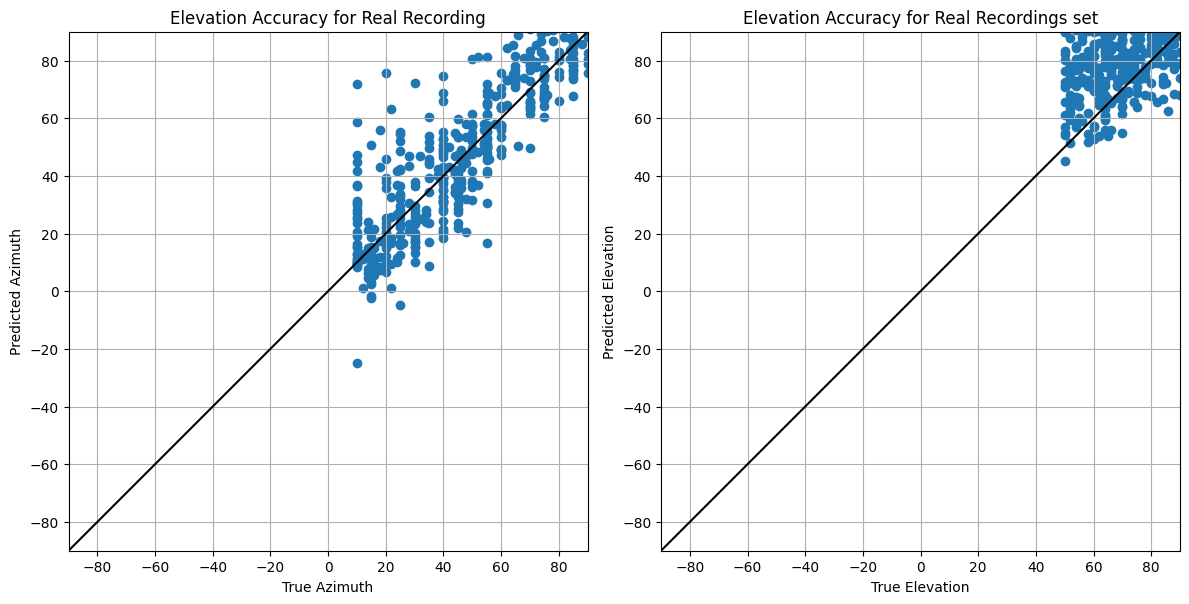

In [30]:
fig=plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.scatter(real_target_az, real_result_az,label="el")
plt.plot([-90,90],[-90,90],'k')
plt.xlabel("True Azimuth")
plt.ylabel("Predicted Azimuth")
plt.axis('square')
plt.ylim((-90,90))
plt.xlim((-90,90))
plt.title("Elevation Accuracy for Real Recording")
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(real_target_el, real_result_el,label="el")
plt.plot([-90,90],[-90,90],'k')
plt.xlabel("True Elevation")
plt.ylabel("Predicted Elevation")
plt.axis('square')
plt.ylim((-90,90))
plt.xlim((-90,90))
plt.title("Elevation Accuracy for Real Recordings set")
plt.grid(True)

plt.tight_layout()
fig.savefig(f"{folder_path}/real_accuracy_plots.png")